In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import SubplotDivider, Size
from datetime import datetime
from dateutil import tz
from dateutil.tz import gettz
import seaborn as sns

/jobfs/89106950.gadi-pbs/ipykernel_170766/486442369.py:10: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# read in two month (Jan-Feb 2022) period BARRA2 data
mypath = "/g/data/v46/yvh565/barra2/yhuang/"
files = [os.path.join(root, f) for root, _, files in os.walk(mypath)
         for f in files
         if f.startswith('av_wnd_ucmp') and f.endswith('.nc')]
barra2_ds = xr.open_mfdataset(files, engine="netcdf4")

In [4]:
# open ds
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,150),y=slice(-22,-11))

In [7]:
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))

lon, lat = np.meshgrid(lon, lat)
dem = ds_bath['z'].data

In [8]:
# create easterly and westerly data
# make sure below is plotting location correctly (latitude value)
Tjan = barra2_ds.av_wnd_ucmp_uv.isel(latitude=362).sel(pressure=850,time=barra2_ds.time.dt.month.isin([1]))
Tjan_west = Tjan.sel(time=Tjan.time.dt.day.isin([1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,23,24,25,26,27,28,31]))
Tjan_east = Tjan.sel(time=Tjan.time.dt.day.isin([10,11,12,20,21,22,29,30]))

Tfeb = barra2_ds.av_wnd_ucmp_uv.isel(latitude=362).sel(pressure=850,time=barra2_ds.time.dt.month.isin([2]))
Tfeb_west = Tfeb.sel(time=Tfeb.time.dt.day.isin([1,2,3,4,9,10,11,12,23,24,25,26,27,28]))
Tfeb_east = Tfeb.sel(time=Tfeb.time.dt.day.isin([5,6,7,8,13,14,15,16,17,18,19,20,21,22,]))

# combine each month westerly and easterly data
Twest = xr.concat([Tjan_west,Tfeb_west],dim="time")
Teast = xr.concat([Tjan_east,Tfeb_east],dim="time")
# find mean u wind by grouping
westerlies = Twest.groupby("time.hour").mean(dim=["time"],skipna=True)
easterlies = Teast.groupby("time.hour").mean(dim=["time"],skipna=True)

In [9]:
# plot mean u (850 hPa)
def plot_mean_u(ds,x0,x1,latitude,regime_data,suptitle,title,level_data,cbar_ticks,cbar_units,bathym_lat,cmap,regime=None,bathymetry=None,
                          townsville=None,willis=None,contour_line_labels=None,bathym=None):    
     # Assign longitude values
    long = ds.longitude
    # Assign (y) times
    time = np.arange(0,8,1)       
    # Assign (z) variable - mean rr data
    if regime==True:
        variable_data = regime_data
    else:
        variable_data = ds.av_wnd_ucmp_uv.isel(latitude=latitude).groupby("time.hour").mean(dim=["time"],skipna=True)
    
    # create plot
    fig = plt.figure(figsize=(18,10))
    if bathymetry==True:
        ax1 = plt.subplot2grid((10, 10), (0, 0), 9, 9)
        ax2 = plt.subplot2grid((10, 10), (9, 0), 1, 9)
        ax3 = plt.subplot2grid((10, 10), (0, 9), 10, 1,frame_on=False)
    else:
        ax1 = fig.add_subplot()
    fig.patch.set_facecolor('white')
    ax1.set_xlim(x0,x1)
    
    # Set some titles
    ax1.set_title(title, loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30,x=0.45,y=0.96)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf = ax1.contourf(long,time,variable_data,levels=levels,cmap=cmap)
    
    # plot contour lines & labels
    line_colors = ['black' for l in cf.levels]
    cs = ax1.contour(long, time, variable_data, alpha=0.4,colors=line_colors, linewidths=0.8,linestyles='-')
    if contour_line_labels==True:
        plt.clabel(cs, fontsize=10,colors="black", inline=1,fmt = '%1.0f')
                    
    
    # plot vertical lines to represent radars
    if townsville==True:
        ax1.axvline(146.55,color='k',alpha=0.5,linestyle='-.')
    else: 
        ax1.axvline(145.68,color='k',alpha=0.5,linestyle='-.')
    
    # plot locations of radars
    if willis==True:
        ax1.axvline(149.96,color='k',alpha=0.5,linestyle='-.')
    
    if bathym==True:
        sel_lat = ds_bath.sel(y=bathym_lat,method="nearest").sel(x=slice(x0,x1))
        ax2.plot(sel_lat["x"],sel_lat["z"])
        ax2.set_xlim(x0,x1)
        ax2.set_ylim(0,1000)
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right') 
        ax2.locator_params(axis='y', nbins=4)
        ax2.set_ylabel("Height (m)")
        ax2.set_xlabel("Longitude",fontsize=20)
        # cbar and cbar label              
        cbar = plt.colorbar(cf, ax=ax3,orientation='vertical', location="right", pad=0.04, aspect=40, extendrect=True,
                         ticks=cbar_ticks)
        cbar.set_label(cbar_units,fontsize=20)
        ax3.set_yticks([])
        ax3.set_xticks([])
        ax1.set_xticklabels([])

    else:    
        # cbar and cbar label              
        cbar = plt.colorbar(cf, ax=ax1,orientation='vertical', location="right", pad=0.04, aspect=40, extendrect=True,
                         ticks=cbar_ticks)
        cbar.set_label(cbar_units,fontsize=15)
        ax1.set_xlabel("Longitude",fontsize=20)
        
    # plot horizontal gridlines
    ax1.grid(visible=None, which='major', axis='y',alpha=0.25)
    # y-ticks & labels
    ax1.set_yticks(np.arange(0,8,1))
    ax1.set_yticklabels(["04:30","07:30","10:30","13:30","16:30","19:30","22:30","01:30"])
    ax1.locator_params(axis='y', nbins=4)
    ax1.set_ylabel("AEST Hour",fontsize=20)            
    plt.show()
    return

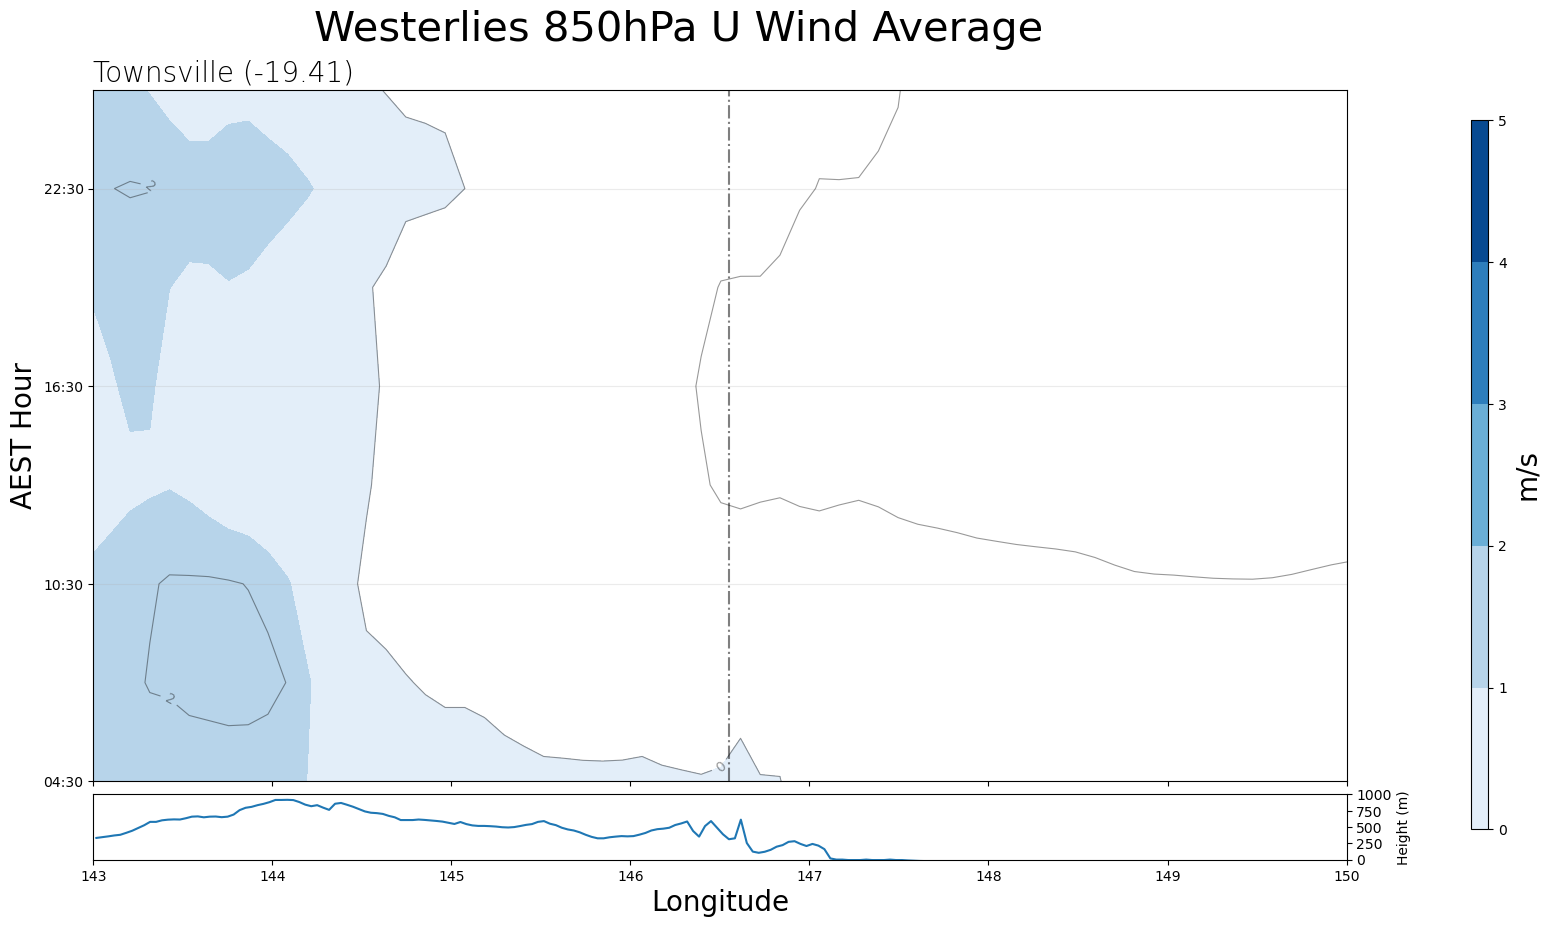

In [40]:
plot_mean_u(barra2_ds,143,150,362,westerlies,"Westerlies 850hPa U Wind Average","Townsville (-19.41)",
             [0,1,2,3,4,5],
             [0,1,2,3,4,5],"m/s",-19.41,"Blues",regime=True,bathymetry=True,
             townsville=True,willis=False,contour_line_labels=True,bathym=True) 

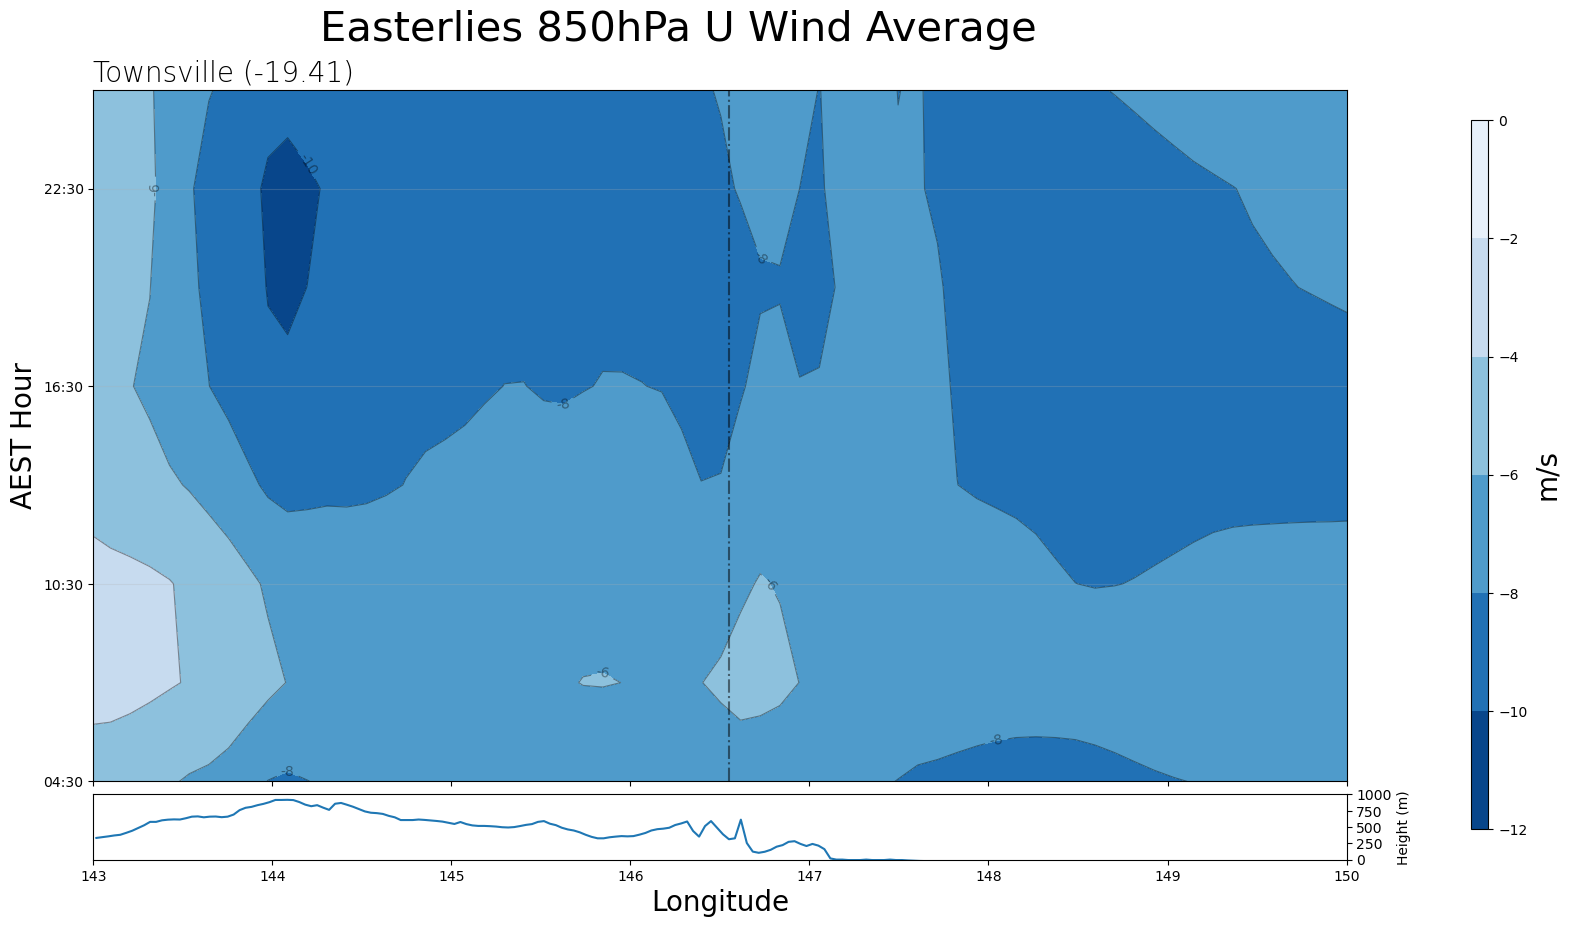

In [12]:
orig_map = plt.cm.get_cmap('Blues')
reversed_map = orig_map.reversed()
plot_mean_u(barra2_ds,143,150,362,easterlies,"Easterlies 850hPa U Wind Average","Townsville (-19.41)",
             [-12,-10,-8,-6,-4,-2,0],
             [-12,-10,-8,-6,-4,-2,0],"m/s",-19.41,reversed_map,regime=True,bathymetry=True,
             townsville=True,willis=False,contour_line_labels=True,bathym=True) 

# Code to separate days in BARRA into wind regimes

In [3]:
import netCDF4
from netCDF4 import Dataset
from metpy.units import units

# open BARRA data - for hourly u 850hPa  
fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/ua1000/"
# open 2022 files
barra2_202201 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202201-202201.nc", engine="netcdf4")
barra2_202202 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202202-202202.nc", engine="netcdf4")
barra2_202203 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202203-202203.nc", engine="netcdf4")
barra2_202204 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202204-202204.nc", engine="netcdf4")
# open 2021 u files
barra2_202101 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202101-202101.nc", engine="netcdf4")
barra2_202102 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202102-202102.nc", engine="netcdf4")
barra2_202103 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202103-202103.nc", engine="netcdf4")
barra2_202104 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202104-202104.nc", engine="netcdf4")
# open 2020 files
barra2_202001 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202001-202001.nc", engine="netcdf4")
barra2_202002 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202002-202002.nc", engine="netcdf4")
barra2_202003 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202003-202003.nc", engine="netcdf4")
barra2_202004 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202004-202004.nc", engine="netcdf4")
# open 2019 files
barra2_201901 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201901-201901.nc", engine="netcdf4")
barra2_201902 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201902-201902.nc", engine="netcdf4")
barra2_201903 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201903-201903.nc", engine="netcdf4")
barra2_201904 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201904-201904.nc", engine="netcdf4")
# open 2018 files
barra2_201801 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201801-201801.nc", engine="netcdf4")
barra2_201802 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201802-201802.nc", engine="netcdf4")
barra2_201803 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201803-201803.nc", engine="netcdf4")
barra2_201804 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201804-201804.nc", engine="netcdf4")

# open dataset for N-S winds
fp1 = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/va1000/"
# open 2022 files
barra2_202201v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202201-202201.nc", engine="netcdf4")
barra2_202202v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202202-202202.nc", engine="netcdf4")
barra2_202203v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202203-202203.nc", engine="netcdf4")
barra2_202204v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202204-202204.nc", engine="netcdf4")
# open 2021 files
barra2_202101v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202101-202101.nc", engine="netcdf4")
barra2_202102v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202102-202102.nc", engine="netcdf4")
barra2_202103v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202103-202103.nc", engine="netcdf4")
barra2_202104v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202104-202104.nc", engine="netcdf4")
# open 2020 files
barra2_202001v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202001-202001.nc", engine="netcdf4")
barra2_202002v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202002-202002.nc", engine="netcdf4")
barra2_202003v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202003-202003.nc", engine="netcdf4")
barra2_202004v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202004-202004.nc", engine="netcdf4")
# open 2019 files
barra2_201901v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201901-201901.nc", engine="netcdf4")
barra2_201902v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201902-201902.nc", engine="netcdf4")
barra2_201903v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201903-201903.nc", engine="netcdf4")
barra2_201904v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201904-201904.nc", engine="netcdf4")
# open 2018 files
barra2_201801v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201801-201801.nc", engine="netcdf4")
barra2_201802v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201802-201802.nc", engine="netcdf4")
barra2_201803v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201803-201803.nc", engine="netcdf4")
barra2_201804v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_201804-201804.nc", engine="netcdf4")

In [ ]:
barra2_202201

In [4]:
# confine datasets to radar lat  lon range 
tv_barra2_202201 = barra2_202201.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"]) #.isel(time=(barra2_202201.time.dt.hour == 4)
tv_barra2_202202 = barra2_202202.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202203 = barra2_202203.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202204 = barra2_202204.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202101 = barra2_202101.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202102 = barra2_202102.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202103 = barra2_202103.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202104 = barra2_202104.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202001 = barra2_202001.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202002 = barra2_202002.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202003 = barra2_202003.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202004 = barra2_202004.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201901 = barra2_201901.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201902 = barra2_201902.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201903 = barra2_201903.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201904 = barra2_201904.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201801 = barra2_201801.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201802 = barra2_201802.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201803 = barra2_201803.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201804 = barra2_201804.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
# v wind
tv_barra2_202201v = barra2_202201v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202202v = barra2_202202v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202203v = barra2_202203v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202204v = barra2_202204v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202101v = barra2_202101v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202102v = barra2_202102v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202103v = barra2_202103v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202104v = barra2_202104v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202001v = barra2_202001v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202002v = barra2_202002v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202003v = barra2_202003v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_202004v = barra2_202004v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201901v = barra2_201901v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201902v = barra2_201902v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201903v = barra2_201903v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201904v = barra2_201904v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201801v = barra2_201801v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201802v = barra2_201802v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201803v = barra2_201803v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])
tv_barra2_201804v = barra2_201804v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").mean(dim=["lat","lon"])

# plot mean wind roses for townsville radar domain 

In [11]:
concat = xr.concat([tv_barra2_202201,tv_barra2_202202,tv_barra2_202203,tv_barra2_202204,tv_barra2_202101,tv_barra2_202102,tv_barra2_202103,tv_barra2_202104,
                   tv_barra2_202001,tv_barra2_202002,tv_barra2_202003,tv_barra2_202004,tv_barra2_201901,tv_barra2_201902,tv_barra2_201903,tv_barra2_201904,
                   tv_barra2_201801,tv_barra2_201802,tv_barra2_201803,tv_barra2_201804],"time")
concat1 = xr.concat([tv_barra2_202201v,tv_barra2_202202v,tv_barra2_202203v,tv_barra2_202204v,tv_barra2_202101v,tv_barra2_202102v,tv_barra2_202103v,tv_barra2_202104v,
                    tv_barra2_202001v,tv_barra2_202002v,tv_barra2_202003v,tv_barra2_202004v,tv_barra2_201901v,tv_barra2_201902v,tv_barra2_201903v,tv_barra2_201904v,
                    tv_barra2_201801v,tv_barra2_201802v,tv_barra2_201803v,tv_barra2_201804v],"time")

In [12]:
concat

<xarray.DataArray 'ua1000' (time: 14424)>
array([ 2.298845 ,  2.8154223,  3.2529216, ..., -8.958968 , -9.287095 ,
       -9.509756 ], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2022-01-01 ... 2018-04-30T23:00:00
    pressure  float64 1e+03

fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/ua1000/"
barra2_202201 = xr.open_dataset(fp+"ua1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202201-202201.nc", engine="netcdf4")
fp1 = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/va1000/"
barra2_202201v = xr.open_dataset(fp1+"va1000_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_202201-202201.nc", engine="netcdf4")
# u wind for local time 23-01-2022
tv_barra2_202201u1 = barra2_202201.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").isel(time=np.logical_and(barra2_202201.time.dt.day==25,barra2_202201.time.dt.hour.isin([13,14,15,16,17,18,19,20,21,22,23]))).mean(dim=["lat","lon"])
tv_barra2_202201u2 = barra2_202201.ua1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").isel(time=np.logical_and(barra2_202201.time.dt.day==26,barra2_202201.time.dt.hour.isin([0,1,2,3,4,5,6,7,8,9,10,11,12]))).mean(dim=["lat","lon"])                                                                                                                   
tv_barra2_202201 = xr.concat([tv_barra2_202201u1,tv_barra2_202201u2],dim="time")
# v wind
tv_barra2_202201v1 = barra2_202201v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").isel(time=np.logical_and(barra2_202201v.time.dt.day==25,barra2_202201v.time.dt.hour.isin([13,14,15,16,17,18,19,20,21,22,23]))).mean(dim=["lat","lon"])
tv_barra2_202201v2 = barra2_202201v.va1000.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest").isel(time=np.logical_and(barra2_202201v.time.dt.day==26,barra2_202201v.time.dt.hour.isin([0,1,2,3,4,5,6,7,8,9,10,11,12]))).mean(dim=["lat","lon"])                                                                                                                  
tv_barra2_202201v = xr.concat([tv_barra2_202201v1,tv_barra2_202201v2],dim="time")

In [13]:
# define u and v and assign units
u_data = concat
uu = u_data * units("m/s")
v_data = concat1
vv = v_data * units("m/s")

In [15]:
wind_dir = metpy.calc.wind_direction(uu, vv, convention='from')
wind_speed = metpy.calc.wind_speed(uu, vv)
direction = wind_dir.values
speed = wind_speed.values

In [26]:
wind_dir

Magnitude,[204.10641479492188 209.7025146484375 215.46484375 ... 117.98587799072266 117.04981994628906 117.04312896728516]
Units,degree


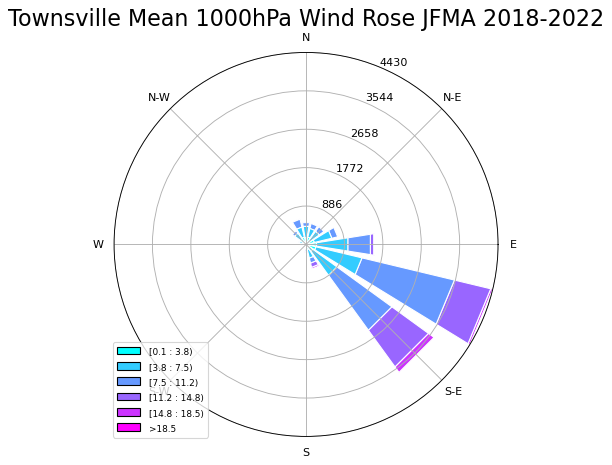

In [28]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm

orig_map = plt.cm.get_cmap('cool')
rev_map = orig_map.reversed()
ax = WindroseAxes.from_ax(figsize=(6,15))
ax.bar(wind_dir, wind_speed, opening=0.8, edgecolor='white', cmap=orig_map)
ax.set_title("Townsville Mean 1000hPa Wind Rose JFMA 2018-2022",fontsize=20)
ax.set_legend();

In [63]:
tv_barra2_202201.lon.values

array([143.03999329, 143.1499939 , 143.25999451, 143.36999512,
       143.47999573, 143.58999634, 143.69999695, 143.80999756,
       143.91999817, 144.02999878, 144.13999939, 144.25      ,
       144.36000061, 144.47000122, 144.58000183, 144.69000244,
       144.79998779, 144.91000366, 145.01998901, 145.13000488,
       145.23999023, 145.34999084, 145.45999146, 145.56999207,
       145.67999268, 145.78999329, 145.8999939 , 146.00999451,
       146.11999512, 146.22999573, 146.33999634, 146.44999695,
       146.55999756, 146.66999817, 146.77999878, 146.88999939,
       147.        , 147.11000061, 147.22000122, 147.33000183,
       147.44000244, 147.54998779, 147.66000366, 147.76998901,
       147.88000488, 147.98999023, 148.09999084, 148.20999146,
       148.31999207, 148.42999268, 148.53999329, 148.6499939 ,
       148.75999451, 148.86999512, 148.97999573, 149.08999634,
       149.19999695, 149.30999756, 149.41999817, 149.52999878,
       149.63999939, 149.75      , 149.86000061, 149.97

In [75]:
# define function to plot
tv_barra2_202201u1 = barra2_202201.ua1000.sel(lat=-19.4198,method="nearest").sel(lon=slice(143,150)).isel(time=np.logical_and(barra2_202201.time.dt.day==22,barra2_202201.time.dt.hour.isin([13,14,15,16,17,18,19,20,21,22,23])))
tv_barra2_202201u2 = barra2_202201.ua1000.sel(lat=-19.4198,method="nearest").sel(lon=slice(143,150)).isel(time=np.logical_and(barra2_202201.time.dt.day==23,barra2_202201.time.dt.hour.isin([0,1,2,3,4,5,6,7,8,9,10,11,12])))                                                                                                                   
tv_barra2_202201 = xr.concat([tv_barra2_202201u1,tv_barra2_202201u2],dim="time")


def plot_hovmoller(suptitle,level_data,cmap,
                   cbar_units,nbins,contour_line_labels=None):  
    # data
    variable_data_T = tv_barra2_202201.values
    # Get times and make array of datetime objects
    variable_times_T = tv_barra2_202201.time.values #.astype('datetime64[ns]').astype('O')
    # Specify lon values for chosen domain
    lons_T = tv_barra2_202201.lon.values
    # make plot
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    fig.patch.set_facecolor('white')
    # Set some titles
    ax.set_title('Townsville (lat=-19.4)', loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30) 

    # Plot of chosen variable averaged over lat and slightly smoothed
    levels = level_data
    cf_T = ax.contourf(lons_T, variable_times_T, variable_data_T, levels=levels, cmap=cmap, extend='both')

    line_colors = ['black' for l in cf_T.levels]
    cs_T = ax.contour(lons_T, variable_times_T, variable_data_T, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')

    # plot contour line labels
    if contour_line_labels==True:
        plt.clabel(cs_T, fontsize=10, inline=1,fmt = '%1.0f')
        
    # cbar and cbar label                
    cbar_T = plt.colorbar(cf_T, ax=ax,orientation='vertical', pad=0.04, aspect=30, extendrect=True,
                         ticks=level_data)
    cbar_T.set_label(cbar_units,fontsize=15)
    
    # plot vertical lines to represent coastlines
    ax.axvline(147.5,color='blue',alpha=0.2,linestyle='--')
    # plot locations of radars
    ax.axvline(146.5509,color='k',alpha=0.5,linestyle='-.')
 
    # Make some ticks and tick labels
    xticks_T = np.arange(143,151,1)       
    ax.set_xticks(xticks_T)
    x_tick_labels_T = ["143","144","145","146","147","148","149","150"]    
    ax.set_xticklabels(x_tick_labels_T)
    ax.grid(visible=None, which='major', axis='y',alpha=0.5)
    ax.set_yticks(variable_times_T)
    ax.set_yticklabels(tv_barra2_202201.time.values.astype('datetime64[s]'))
    ax.locator_params(axis='y', nbins=nbins)
    ax.set_xlabel("lon",fontsize=15)
    ax.set_ylabel("UTC",fontsize=20)                          
    fig.tight_layout()
    plt.show()
    return

AttributeError: 'Dataset' object has no attribute 'ua850'

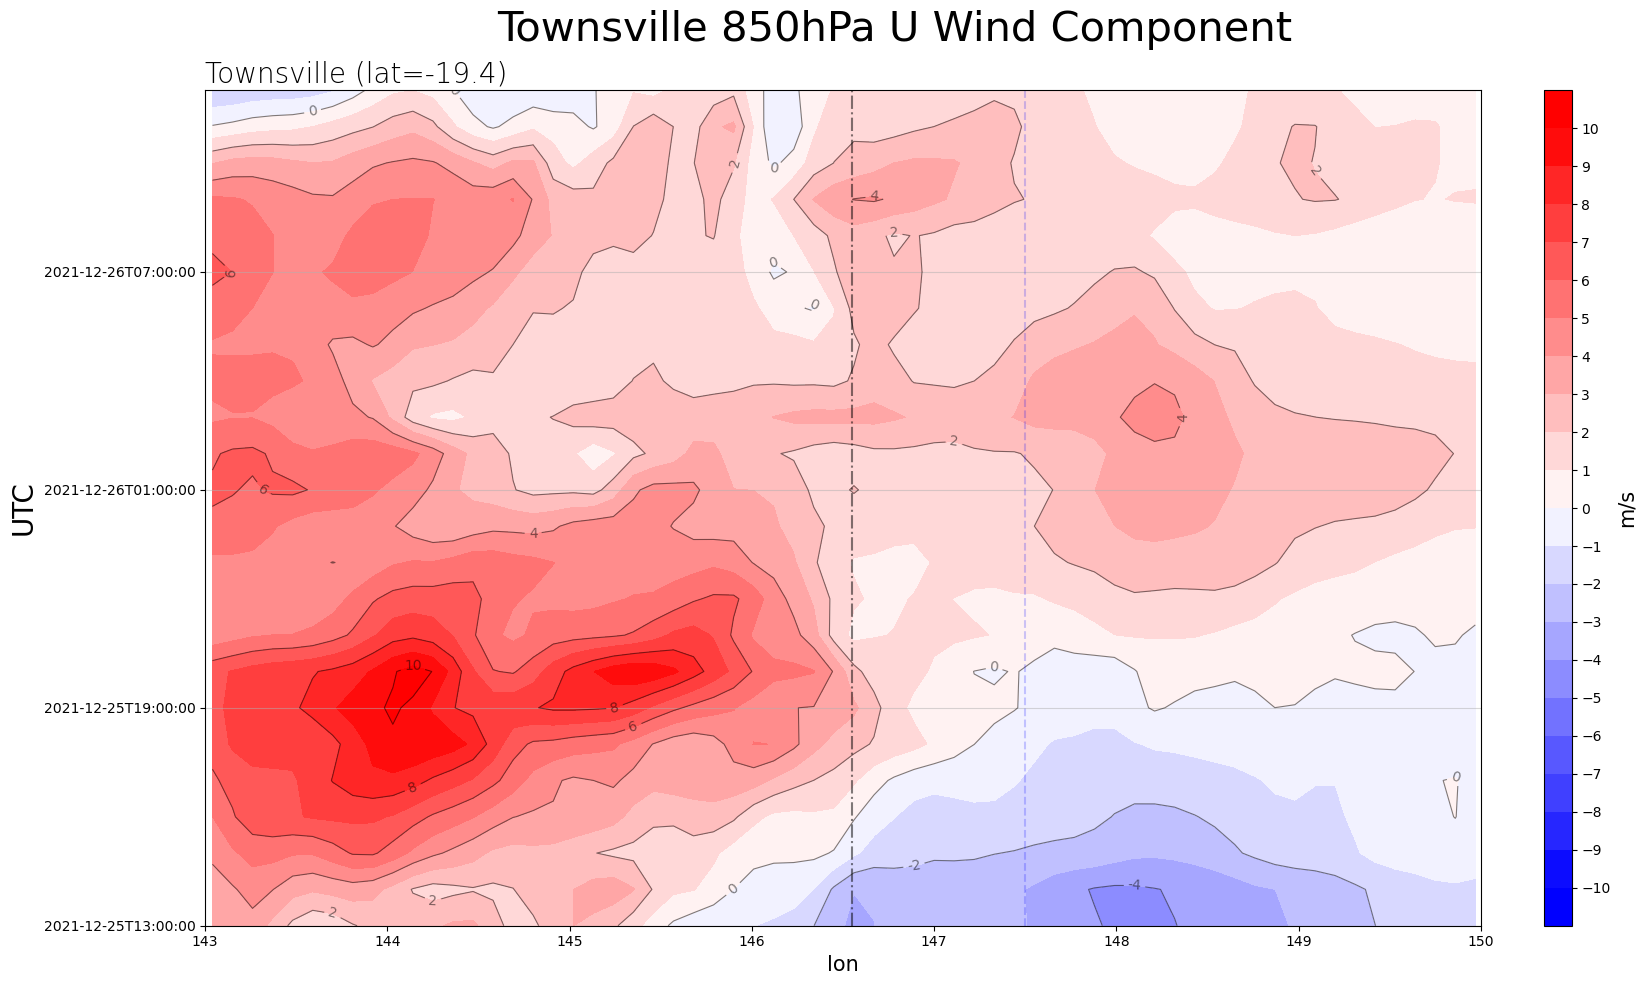

In [76]:
plot_hovmoller("Townsville 850hPa U Wind Component",[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10],"bwr","m/s",4,contour_line_labels=True)

# function to separate wind regime days

In [22]:
def separate_days_into_wind_regimes_separate_months(ds):
    days = ds.groupby("time.day")
    mean_westerly = []
    mean_easterly = []
    no_u = []
    for i in np.arange(1,len(days)+1,1):
        u = days[i].mean().values
        if u >1:
            mean_westerly.append(u)
            mean_westerly.append(i)
        elif u<-1:
            mean_easterly.append(u)
            mean_easterly.append(i)
        else:
            no_u.append(u)
            no_u.append(i)
    return mean_westerly, mean_easterly, no_u

In [23]:
separate_days_into_wind_regimes_separate_months(tv_barra2_202201)

([array(2.5601707, dtype=float32),
  1,
  array(3.409565, dtype=float32),
  2,
  array(3.9376476, dtype=float32),
  4,
  array(5.7996545, dtype=float32),
  5,
  array(3.5062017, dtype=float32),
  6,
  array(2.266205, dtype=float32),
  26],
 [array(-2.7153091, dtype=float32),
  8,
  array(-6.312162, dtype=float32),
  9,
  array(-9.796329, dtype=float32),
  10,
  array(-8.86558, dtype=float32),
  11,
  array(-6.231852, dtype=float32),
  12,
  array(-4.6777267, dtype=float32),
  13,
  array(-2.174516, dtype=float32),
  14,
  array(-3.9271176, dtype=float32),
  18,
  array(-7.1364493, dtype=float32),
  19,
  array(-10.447062, dtype=float32),
  20,
  array(-13.342343, dtype=float32),
  21,
  array(-10.002711, dtype=float32),
  22,
  array(-5.7931266, dtype=float32),
  23,
  array(-3.0633152, dtype=float32),
  24,
  array(-1.0582266, dtype=float32),
  25,
  array(-9.234971, dtype=float32),
  28,
  array(-8.804248, dtype=float32),
  29,
  array(-5.4147015, dtype=float32),
  30],
 [array(0.553

In [129]:
def separate_days_into_wind_regimes(latitude,longitude,pressure,year,month):
    site = barra2_ds.av_wnd_ucmp_uv.isel(latitude=latitude).sel(longitude=longitude,pressure=pressure,time=barra2_ds.time.dt.year.isin([year]))
    site_month = site.sel(time=barra2_ds.time.dt.month.isin([month]),method="nearest")
    days = site_month.groupby("time.day")
    mean_westerly = []
    mean_easterly = []
    no_u = []
    for i in np.arange(1,len(days)+1,1):
        u = townsville_wnd_day[i].mean().values
        if u >1:
            mean_westerly.append(u)
            mean_westerly.append(i)
        elif u<-1:
            mean_easterly.append(u)
            mean_easterly.append(i)
        else:
            mean_u.append(u)
            no_u.append(i)
    return mean_westerly, mean_easterly, no_u

In [138]:
townsville_wnd = barra2_ds.av_wnd_ucmp_uv.sel(latitude=-19.4192,longitude=[143,150],pressure=1000,
                 time=barra2_ds.time.dt.month.isin([1]),method="nearest")
townsville_wnd_day = townsville_wnd.groupby("time.day")

In [139]:
mean_westerly = []
mean_easterly = []
mean_u = []
for i in np.arange(1,len(townsville_wnd_day)+1,1):
    u = townsville_wnd_day[i].mean().values
    if u >1:
        mean_westerly.append(u)
        mean_westerly.append(i)
    elif u<-1:
        mean_easterly.append(u)
        mean_easterly.append(i)
    else:
        mean_u.append(u)
        mean_u.append(i)

In [148]:
mean_u

[array(-0.18024554),
 1,
 array(0.52172852),
 2,
 array(0.41064453),
 6,
 array(-0.02197266),
 7,
 array(-0.79541016),
 8,
 array(-0.43237305),
 16]

In [147]:
array = np.array(mean_u)
u = array.reshape(6,2) # shape needs len(mean_u)
u

array([[-0.18024554,  1.        ],
       [ 0.52172852,  2.        ],
       [ 0.41064453,  6.        ],
       [-0.02197266,  7.        ],
       [-0.79541016,  8.        ],
       [-0.43237305, 16.        ]])

In [56]:
u = townsville_wnd_day[6].mean()
u

<xarray.DataArray 'av_wnd_ucmp_uv' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    pressure  float64 850.0
    latitude  float64 -19.42